#### Since we have more than 50 samples, want to predict a category, have labeled data, and have less than 100k entries, we start with a linear SVC. Then we examine the categories and consider preprocessing, and feature selection

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import *
import pandas as pd
import seaborn as sns
import numpy as np
sns.set(style="ticks", color_codes=True)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Label each category for easy comprehension

In [2]:
names = ['in_id','clump_thick','cell_size','cell_shape','marg_adh','epit_cell_size','bare_nucl',
         'bland_chrom','norm_nucl','mitoses','bm_class']

#### Extract comma delimited file using read_csv with the category names as keys

In [3]:
in_data = pd.read_csv("data/breast-cancer-wisconsin.data",names=names)

#### Separate classifier (benign vs malignant) and features (everything except the in_id, which are unique identifiers for all the participants)

In [4]:
y_class = np.array(in_data['bm_class'].as_matrix().astype(np.int))
x_data=np.array(in_data.drop(['in_id','bm_class'],1).as_matrix().astype(np.int))

#### Get support vector machine, cross validation and scoring metrics from scikit-learn

In [5]:
from sklearn import svm
from sklearn import cross_validation
from sklearn import metrics

#### Implement brute force k fold cross validation

In [6]:
#Get test sets from k folds and train on remainder k times to determine the prediction accuracy of different 
# ML techniques. Applied stratified to get comparable result with scikit-learn prediction. Return vector of final 
# predictions and coefficients
def kfold_cv(X, y, clf_class, n_folds=10, **kwargs):
    coefficients = []
#Define cross validation folds
    k_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds)    
    y_pred = y.copy()
#Train algorithm on k folds
    for ii, jj in k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
        coefficients.append(clf.coef_)
    return y_pred,coefficients

#### Get brute force cross validation score

In [7]:
svm_classifier,coeffs = kfold_cv(x_data, y_class, svm.SVC,kernel='linear', C=1)
print '{:.2f}'.format(metrics.accuracy_score(y_class, svm_classifier))

0.97


#### Compare to score from scikit-learn cross_val_score

In [8]:
#Innate scikit-learn score
clf = svm.SVC(kernel='linear', C=1)
scores = cross_validation.cross_val_score(clf, x_data, y_class, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.03)


#### Accuracy of support vector machine seems good. But it is important to also see what the breakdown is in terms of true vs predicted positive and negative. So we will use a confusion matrix

In [9]:
conf_matrix = metrics.confusion_matrix(y_class,svm_classifier)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


#### We see that the classifier is failing for exactly 23 cases. Of those more than half are false positives

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


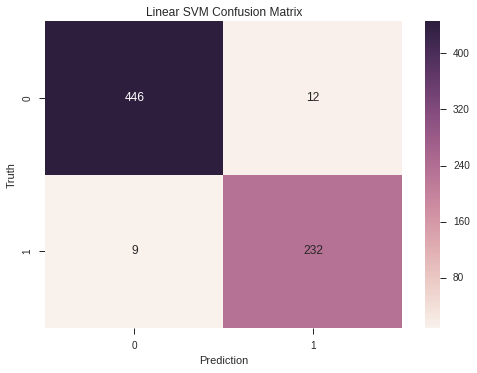

In [10]:
matplotlib.pyplot.title('Linear SVM Confusion Matrix')
sns.heatmap(conf_matrix, annot=True,  fmt='')
matplotlib.pyplot.xlabel("Prediction")
matplotlib.pyplot.ylabel('Truth')

#### We get the indexes of the failures in order to see if there are any trends

In [11]:
print np.nonzero(svm_classifier-y_class)[0],len(np.nonzero(svm_classifier-y_class)[0])

[  1   3  12  40  43  51 101 196 222 232 252 259 296 315 319 348 356 434
 488 489 494] 21


In [12]:
x_data[np.nonzero(svm_classifier-y_class)],x_data[40]

(array([[ 5,  4,  4,  5,  7, 10,  3,  2,  1],
        [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
        [ 5,  3,  3,  3,  2,  3,  4,  4,  1],
        [ 6,  6,  6,  9,  6,  0,  7,  8,  1],
        [ 5,  6,  5,  6, 10,  1,  3,  1,  1],
        [ 5,  3,  3,  4,  2,  4,  3,  4,  1],
        [ 2,  3,  4,  4,  2,  5,  2,  5,  1],
        [ 8,  4,  4,  5,  4,  7,  7,  8,  2],
        [ 4,  1,  1,  3,  1,  5,  2,  1,  1],
        [ 8,  4,  6,  3,  3,  1,  4,  3,  1],
        [ 6,  3,  3,  5,  3, 10,  3,  5,  3],
        [ 5,  7,  7,  1,  5,  8,  3,  4,  1],
        [ 5,  3,  4,  3,  4,  5,  4,  7,  1],
        [ 4,  6,  5,  6,  7,  0,  4,  9,  1],
        [ 4,  4,  4,  4,  6,  5,  7,  3,  1],
        [ 3,  4,  4, 10,  5,  1,  3,  3,  1],
        [ 5,  3,  3,  1,  3,  3,  3,  3,  3],
        [ 6,  9,  7,  5,  5,  8,  4,  2,  1],
        [ 3,  6,  4, 10,  3,  3,  3,  4,  1],
        [ 6,  3,  2,  1,  3,  4,  4,  1,  1],
        [ 5,  1,  2, 10,  4,  5,  2,  1,  1]]),
 array([6, 6, 6, 9, 6, 0, 7, 8, 

#### From this I realize that ? entries have been formatted incorrectly, so it is not easy to see what the effect is. Try doing same process with ? entries removed

In [13]:
new_data = in_data.replace({'?':np.nan})
new_data = new_data.dropna()
y_class = numpy.array(new_data['bm_class'].as_matrix().astype(np.int))
x_data = numpy.array(new_data.drop(['in_id','bm_class'],1).as_matrix().astype(np.int))

683
683


#### See that accuracy decreases

In [14]:
svm_classifier,coeffs = kfold_cv(x_data, y_class, svm.SVC,kernel='linear', C=1)
print '{:.2f}'.format(metrics.accuracy_score(y_class, svm_classifier))

0.96


#### See that number of mis-identified entries increased to 26

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


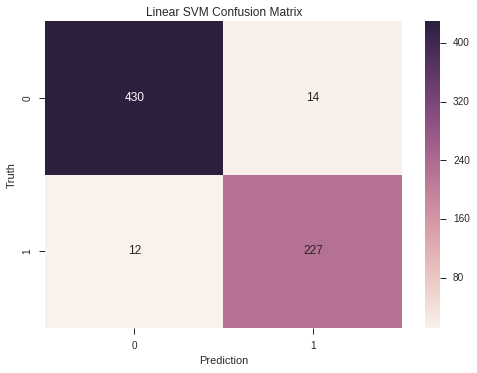

In [15]:
conf_matrix = metrics.confusion_matrix(y_class,svm_classifier)
matplotlib.pyplot.title('Linear SVM Confusion Matrix')
sns.heatmap(conf_matrix, annot=True,  fmt='')
matplotlib.pyplot.xlabel("Prediction")
matplotlib.pyplot.ylabel('Truth')

#### Add preprocessing to correctly impute the ? entries

In [16]:
from sklearn import preprocessing

In [17]:
imp_data = in_data.replace({'?':np.nan})

In [18]:
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)

In [19]:
y_class = numpy.array(imp_data['bm_class'].as_matrix().astype(np.int))
#x_data = imp_data.drop(['in_id','bm_class'],1).as_matrix().astype(np.int)
x_data = imp.fit_transform(imp_data.drop(['in_id','bm_class'],1))
x_data = numpy.array(x_data.astype(np.int))

#### Get 22 failures instead of 23 by imputing ? entries, and now ? is correctly implemented

In [20]:
svm_classifier,coeffs = kfold_cv(x_data, y_class, svm.SVC,kernel='linear', C=1)
print '{:.2f}'.format(metrics.accuracy_score(y_class, svm_classifier))

0.97


/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


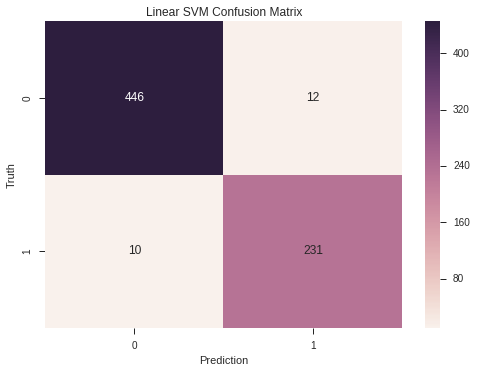

In [21]:
conf_matrix = metrics.confusion_matrix(y_class,svm_classifier)
matplotlib.pyplot.title('Linear SVM Confusion Matrix')
sns.heatmap(conf_matrix, annot=True,  fmt='')
matplotlib.pyplot.xlabel("Prediction")
matplotlib.pyplot.ylabel('Truth')

#### Get coefficients for Linear SVM for each of the 10 folds

In [22]:
ravels= [c.ravel() for c in coeffs]

#### Plot most important coefficients in order. See that most important features are fairly consistent, but do somewhat depend on the fold

In [23]:
def plot_coefficients(coef, feature_names, top_features=20):
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 matplotlib.pyplot.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 matplotlib.pyplot.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 matplotlib.pyplot.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 matplotlib.pyplot.show()

#### Clump thickness is most important feature most often, in 8/10 of the folds, with mitoses most important in 2/10 folds

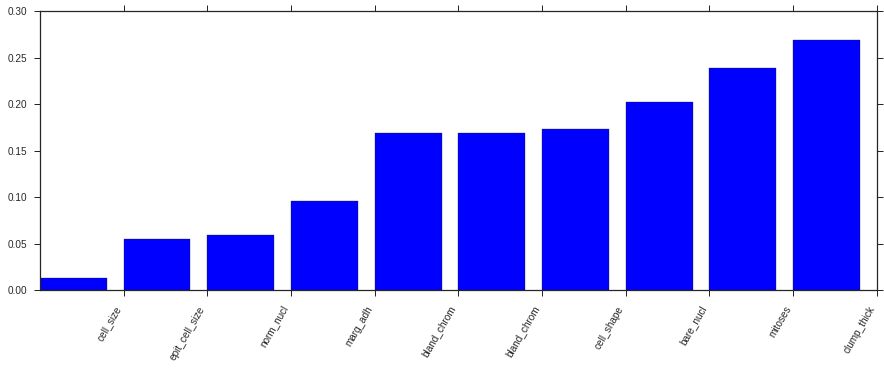

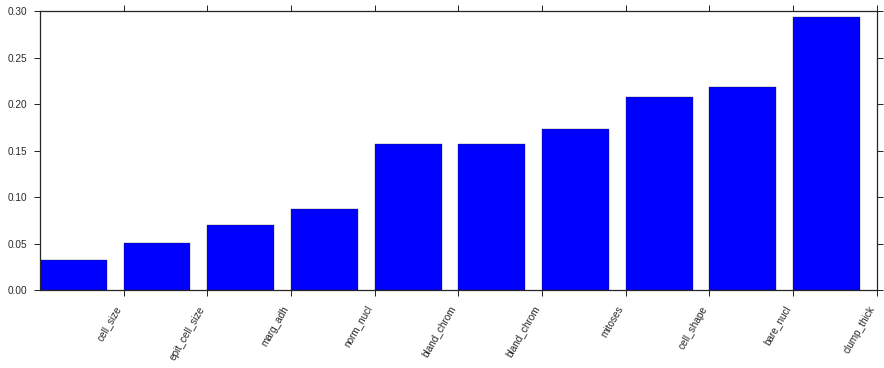

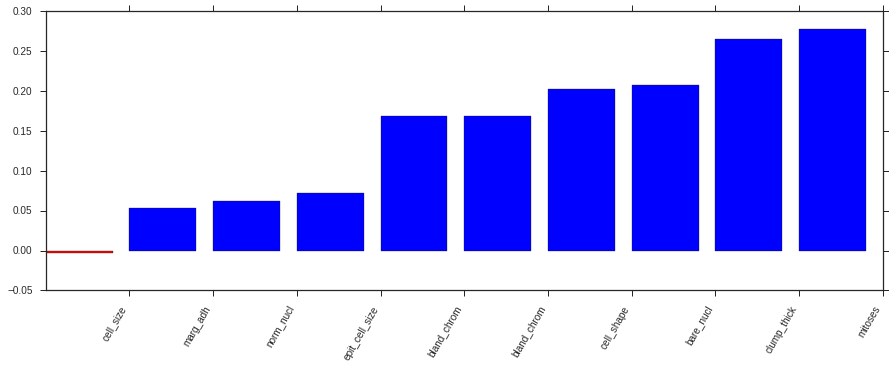

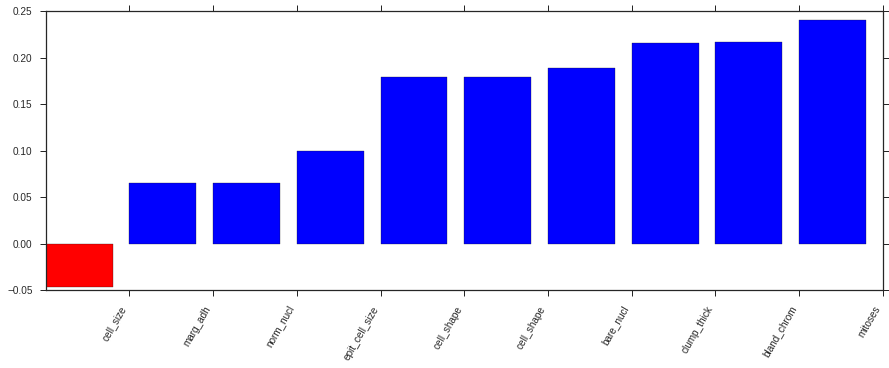

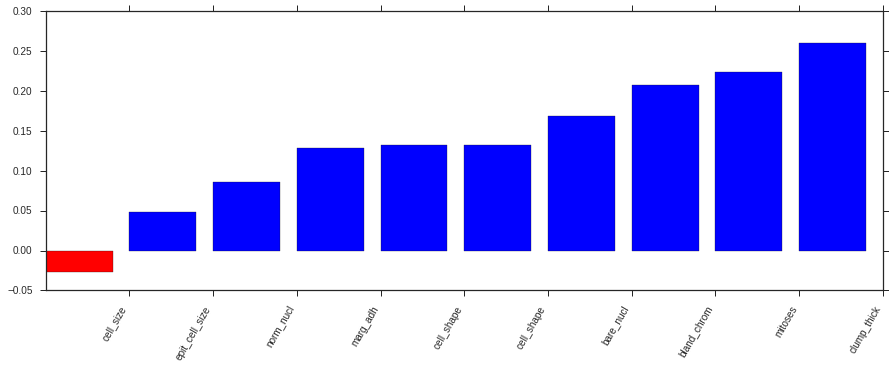

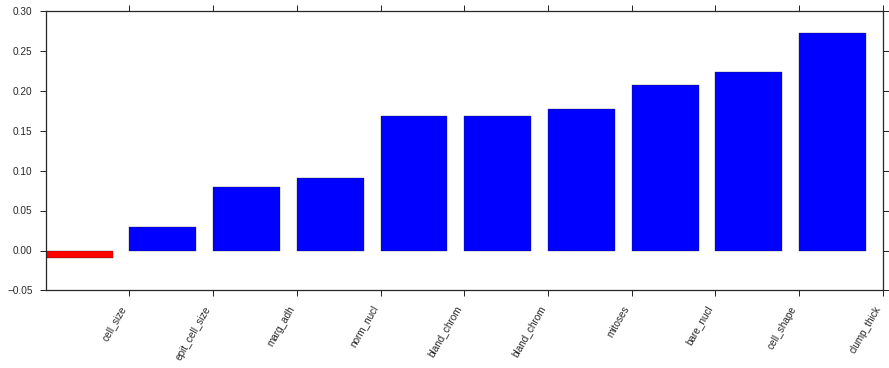

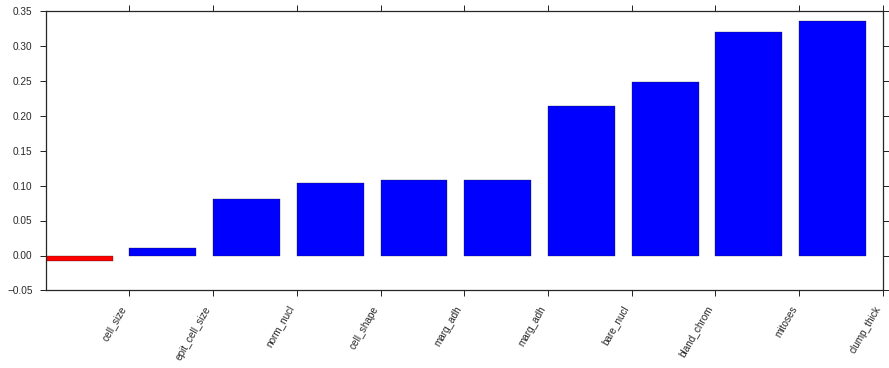

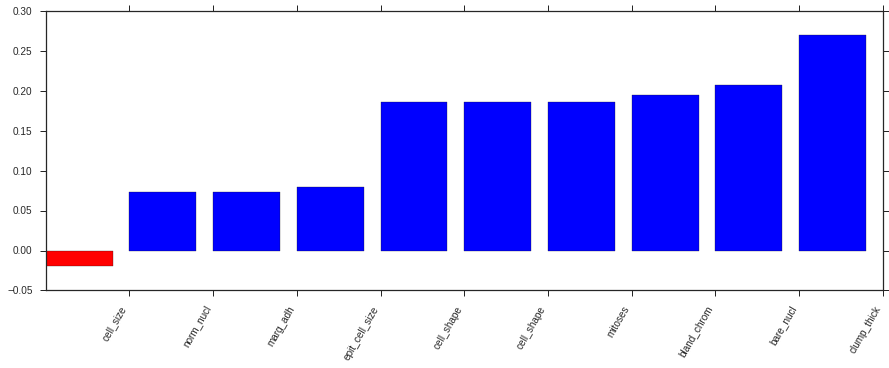

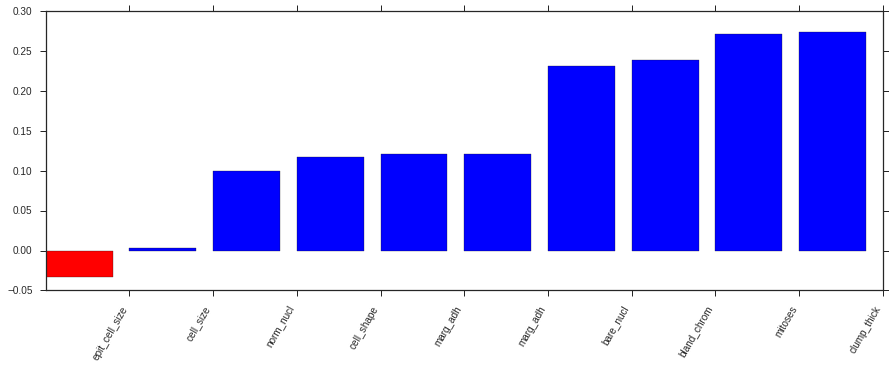

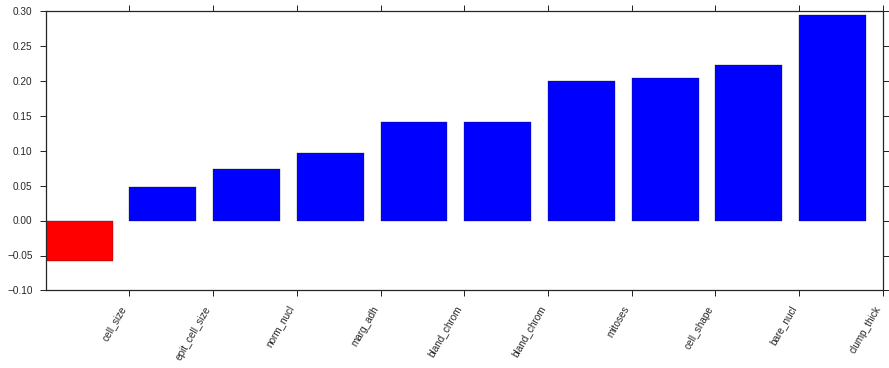

In [24]:
for rav in ravels:
    plot_coefficients(rav,names[1:10],5)

In [37]:
from scipy import stats
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = matplotlib.pyplot.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

#### Top four features are about 2-3 times as significant as bottom four features. Probably dimensionality reduction is possible. Examine most and least significant features and look at their correlations

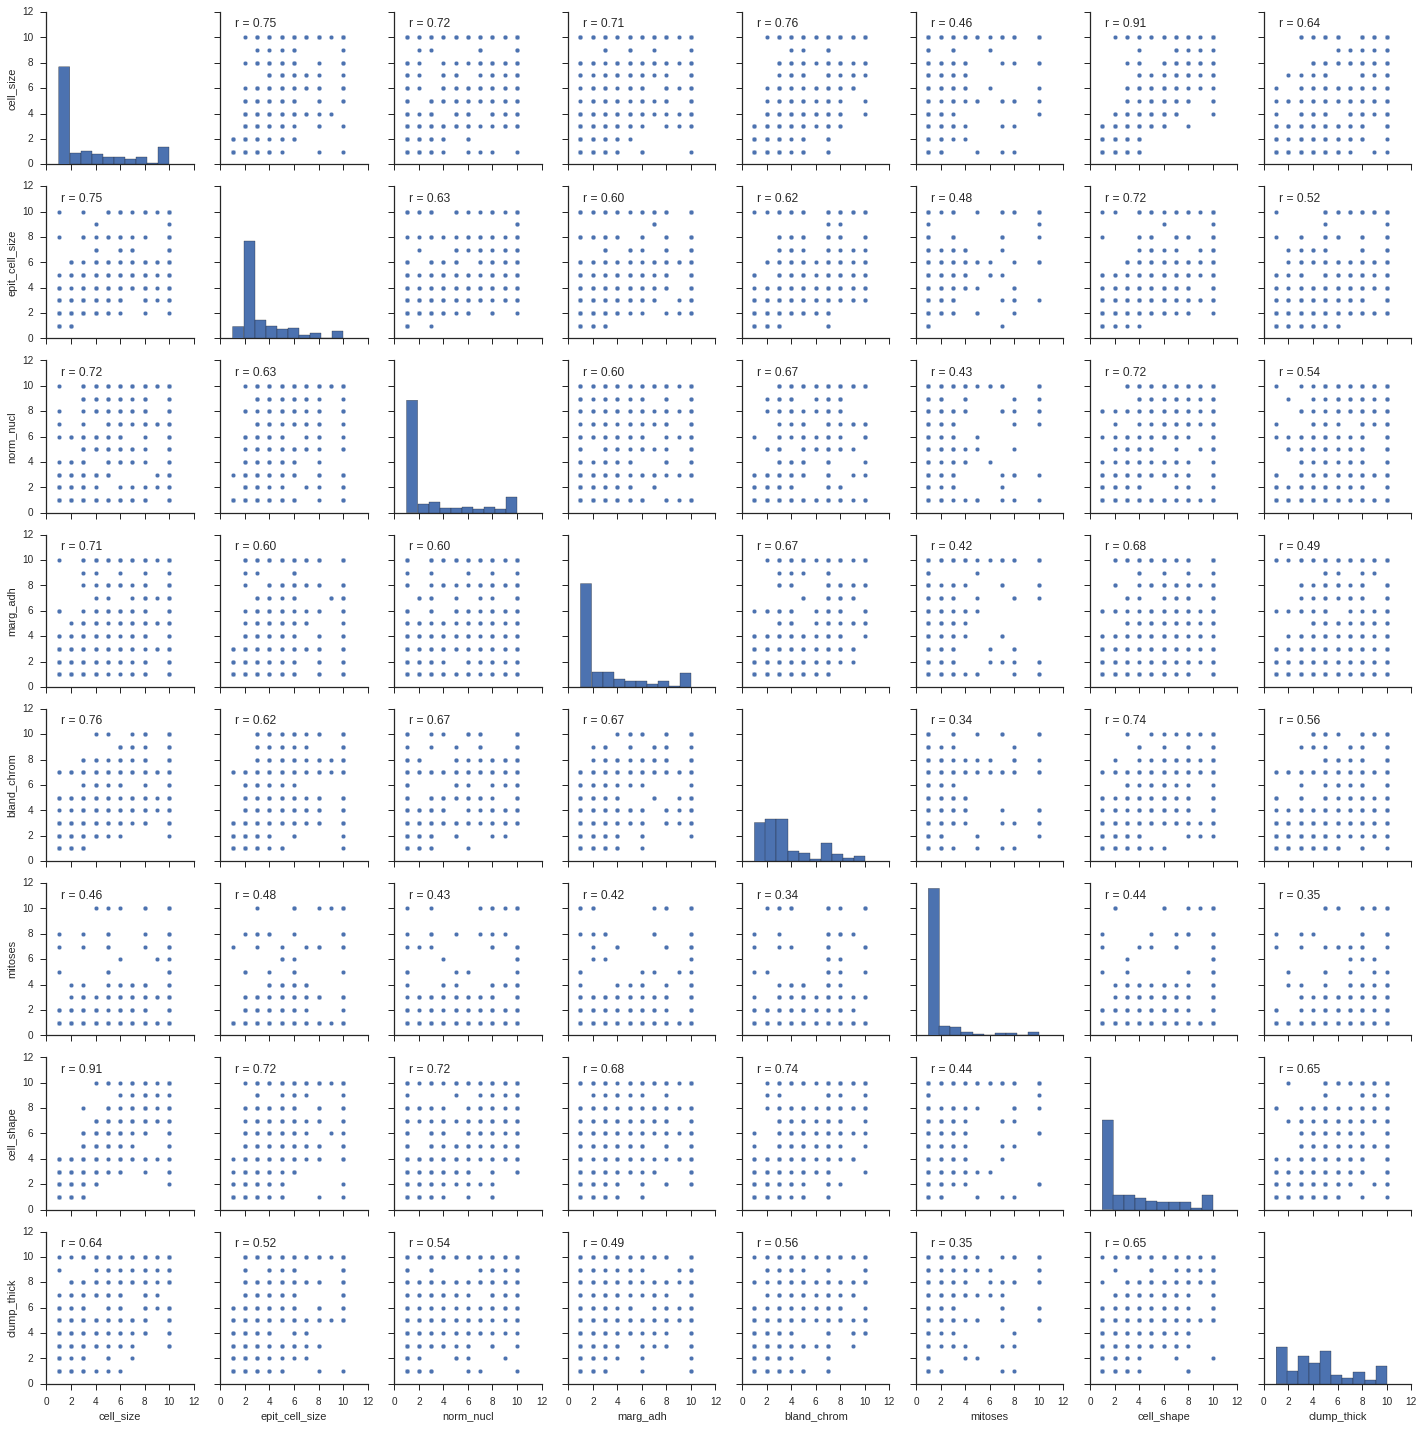

In [44]:
both_plot = sns.pairplot(in_data,vars=['cell_size','epit_cell_size','norm_nucl','marg_adh','bland_chrom','mitoses','cell_shape','clump_thick'])
both_plot.map_upper(corrfunc)
both_plot.map_lower(corrfunc)

#### See that features with less importance are more correlated with each other

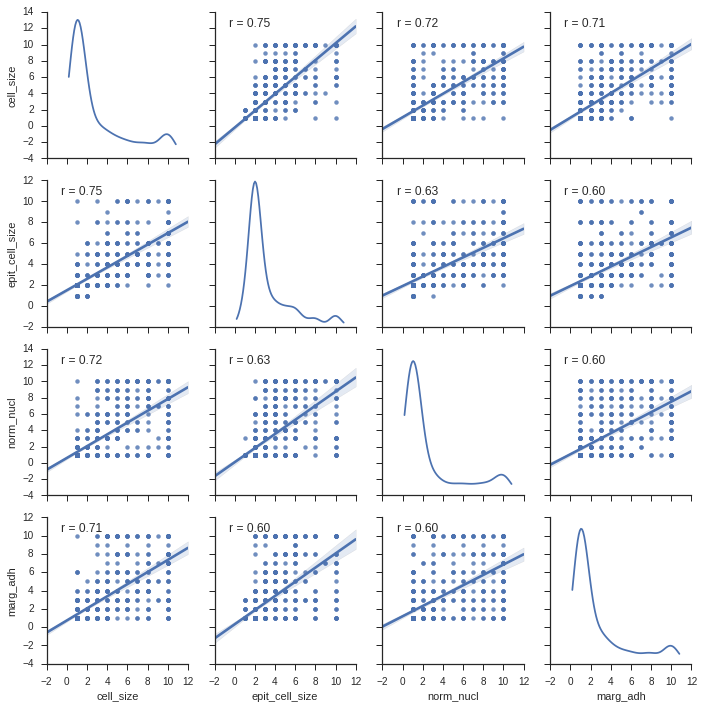

In [39]:
li_plot = sns.pairplot(in_data,vars=['cell_size','epit_cell_size','norm_nucl','marg_adh'],kind='reg',diag_kind='kde')
li_plot.map_upper(corrfunc)
li_plot.map_lower(corrfunc)

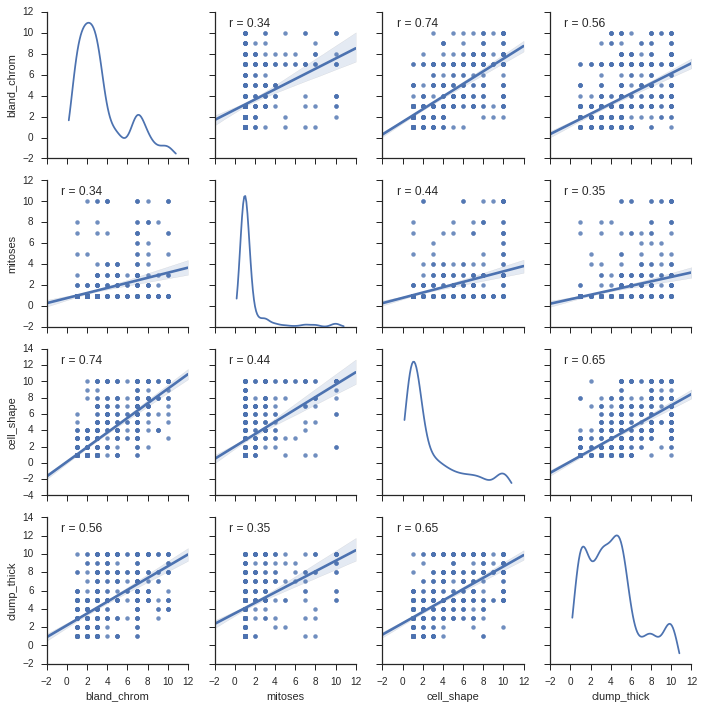

In [40]:
mi_plot = sns.pairplot(in_data,vars=['bland_chrom','mitoses','cell_shape','clump_thick'],kind='reg',diag_kind='kde')
mi_plot.map_upper(corrfunc)
mi_plot.map_lower(corrfunc)